In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE



In [2]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv" # path for the preprocessed datadet
!wget $path


--2022-02-07 13:02:40--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3429217 (3.3M) [text/plain]
Saving to: ‘dataset_cleaned.csv’

dataset_cleaned.csv 100%[===================>]   3.27M  --.-KB/s    in 0.09s   

2022-02-07 13:02:41 (36.4 MB/s) - ‘dataset_cleaned.csv’ saved [3429217/3429217]



In [3]:
df = pd.read_csv("dataset_cleaned.csv", index_col="PROC_TRACEINFO")

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

features = list(df.columns)[:-1]

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train["results"]
y_test = df_test["results"]
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#smote = SMOTE() don't balance for unsupervised method

#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
#pd.value_counts(y_train_balanced)

Scaled balanced dataset


The  12  singular values are
[298.74783202 204.3289927  184.0578272  176.80462265 170.29617792
 159.67683396 150.38081705 145.04129317 123.18148315 105.19083512
  90.40049597  51.4427023 ]



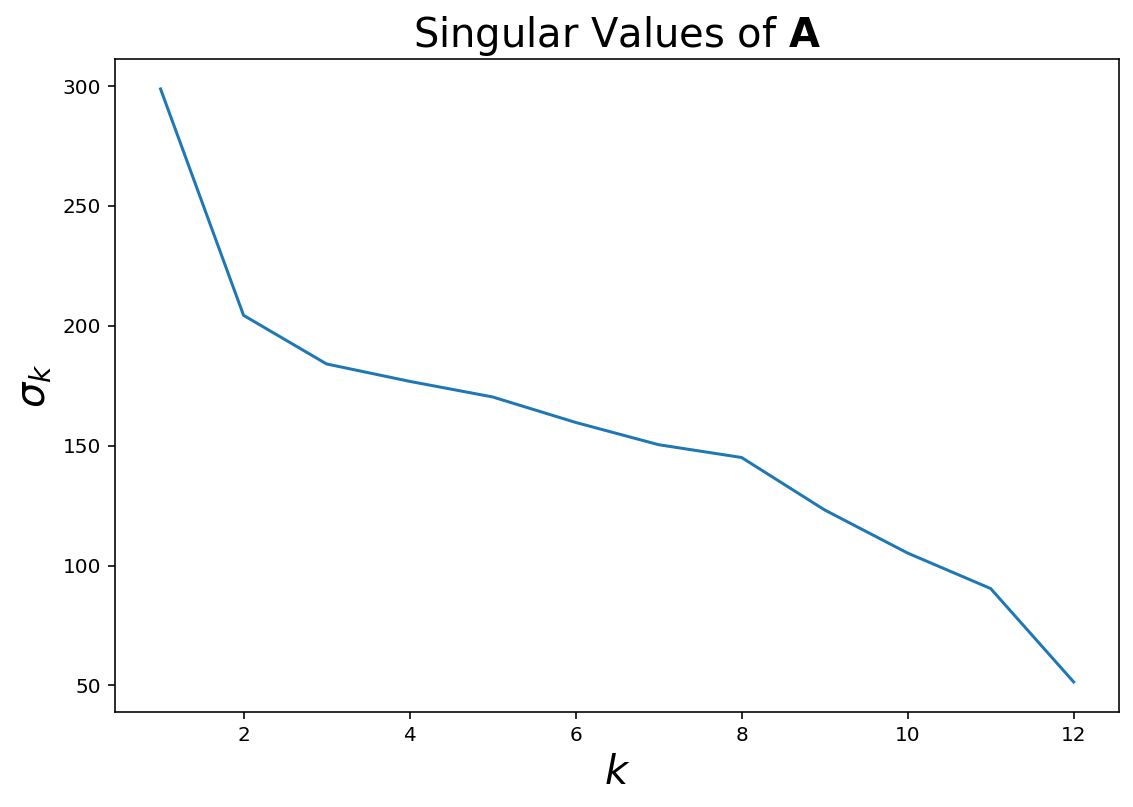

In [5]:
U,Sigma,Vt = np.linalg.svd(X_train_scaled,full_matrices=False)

print("The ", len(Sigma), " singular values are")
print(Sigma)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(Sigma)),Sigma)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
plt.title(r'Singular Values of $\mathbf{A}$',size=20)
print('')
#let's look at the cumulative plot now

The largest 8 singular values, normalized by the Froebenius norm of A:
[0.51899743 0.35496901 0.31975308 0.3071525  0.29584576 0.27739738
 0.26124795 0.2519719 ]



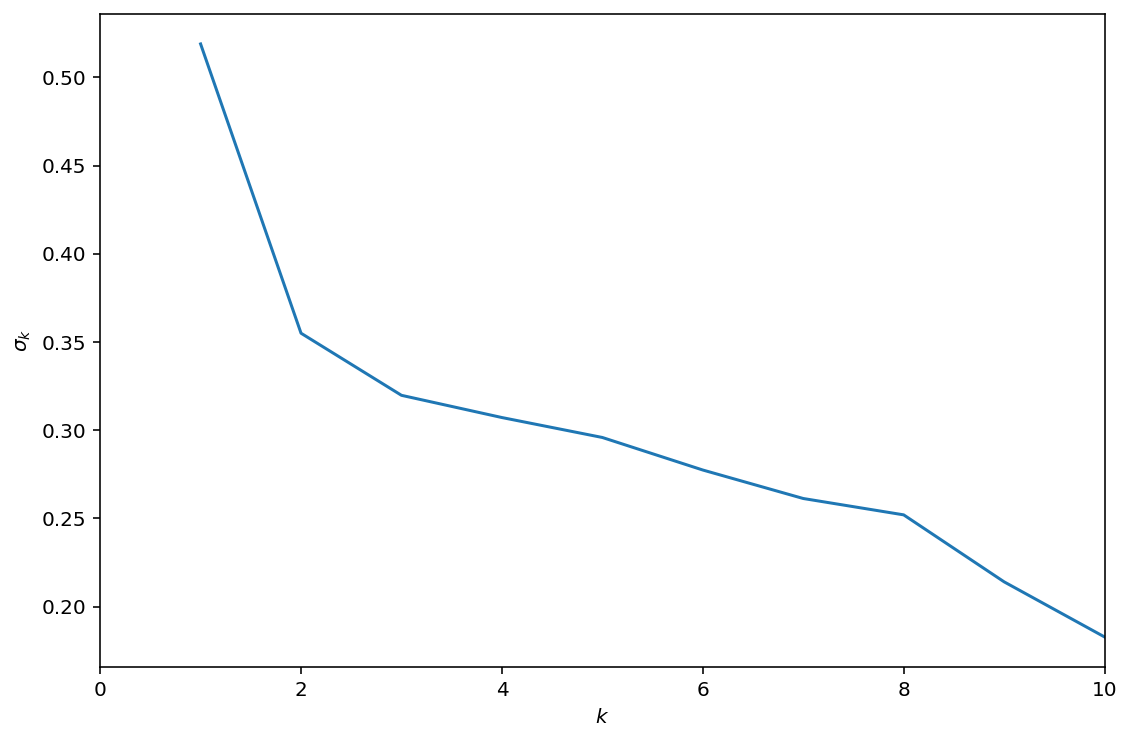

In [6]:
Anorm = np.linalg.norm(X_train_scaled) # Froebenius norm
k=10

print("The largest 10 singular values, normalized by the Froebenius norm of A:")
print(Sigma[0:8]/Anorm)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,k+1),Sigma[0:k]/Anorm)
plt.xlim([0,k])
plt.xlabel(r'$k$',size=k)
plt.ylabel(r'$\sigma_k$',size=k)
print('')

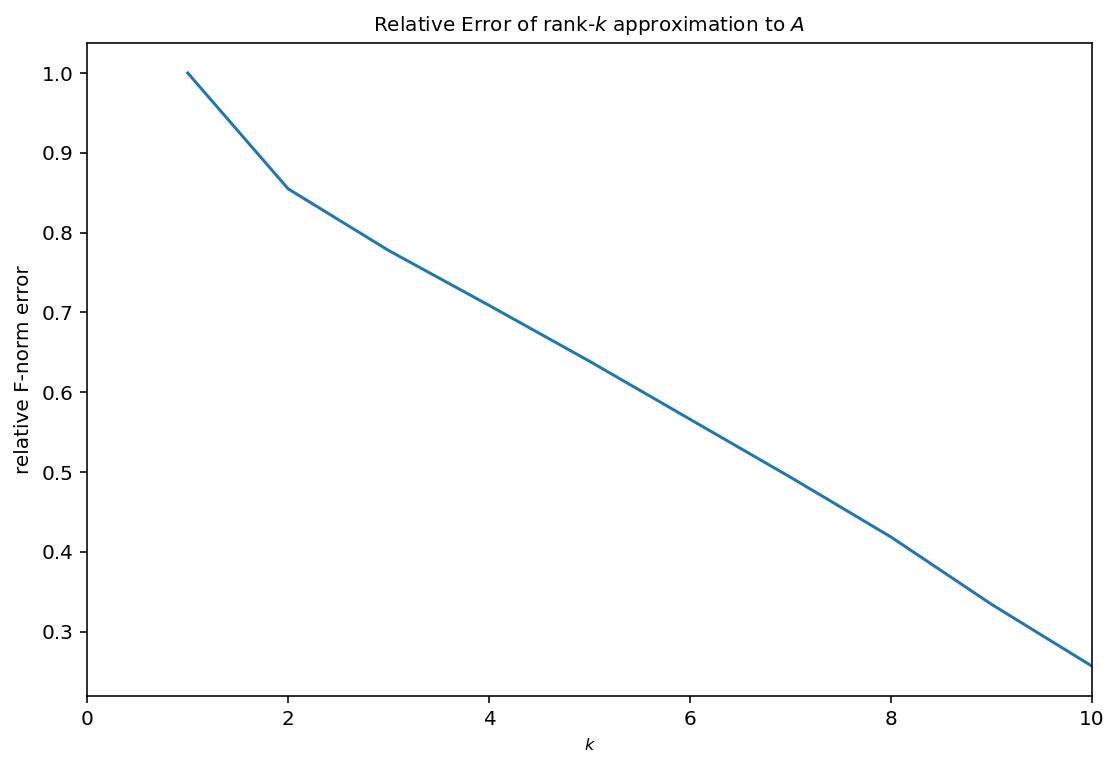

In [7]:
err = np.cumsum(Sigma[::-1]**2)
err = np.sqrt(err[::-1])

# Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,k+1),err[:k]/Anorm) # Error in percentage
plt.xlim([0,k])
plt.xlabel(r'$k$',size=8)
plt.ylabel(r'relative F-norm error',size=k)
plt.title(r'Relative Error of rank-$k$ approximation to $A$',size=k)
print('')

Text(0.5, 1.0, 'Cumulative normalized variance explained of X_train')

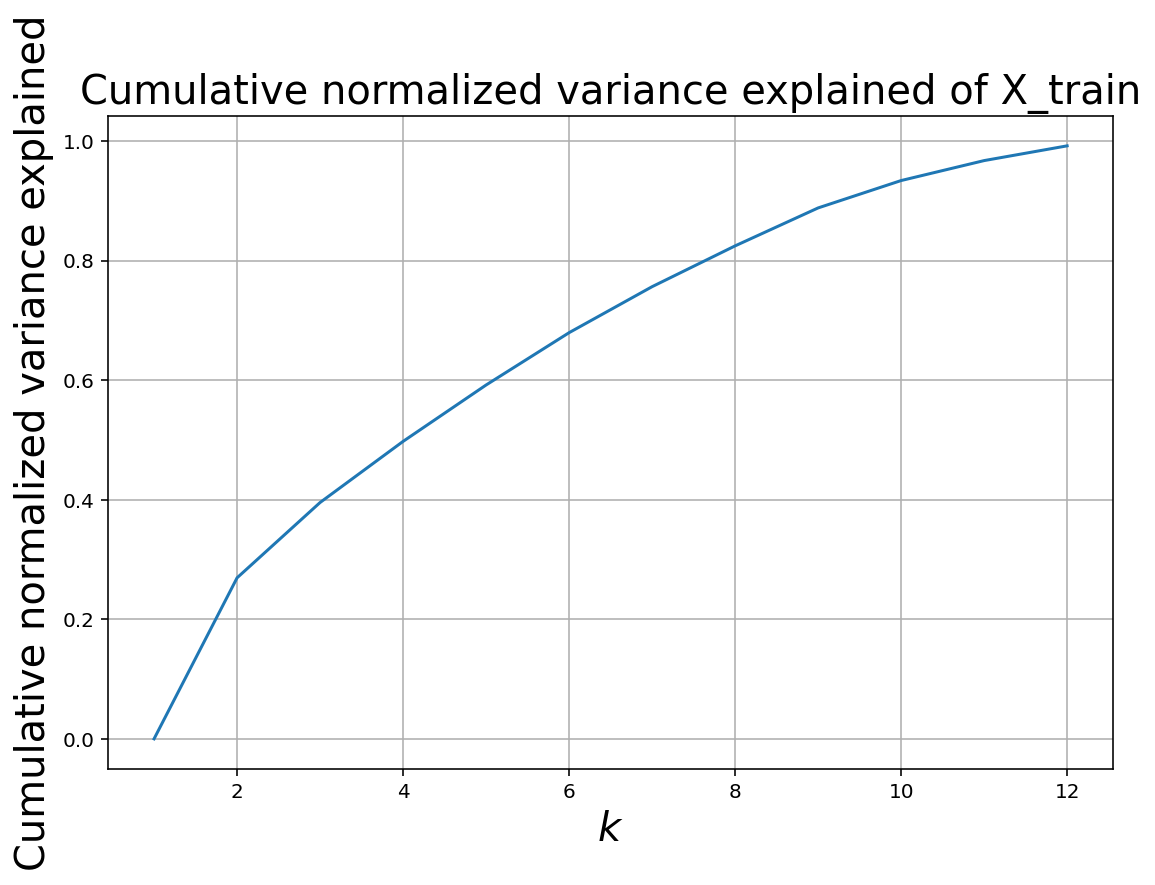

In [8]:
Sigma_squared = np.square(Sigma)
total_variance = sum(Sigma_squared)
cumul = [ sum(Sigma_squared[0:i]/total_variance) for i in range(len(Sigma_squared))]

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(cumul)),cumul)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'Cumulative normalized variance explained',size=20)
plt.grid(b=True)
plt.title(r'Cumulative normalized variance explained of X_train',size=20)

In [9]:
print(X_train_scaled.shape)


(27612, 12)


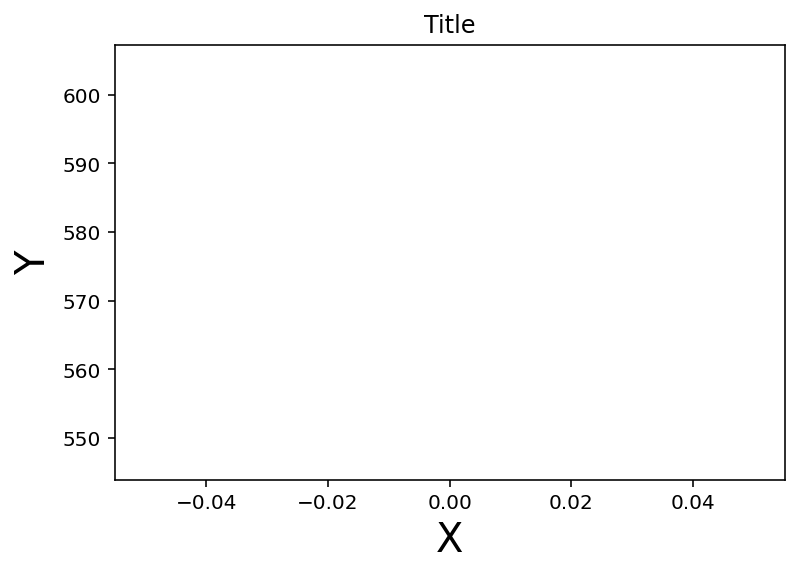

In [25]:
def numberK(k):
  U_k = U[:,0:k]
  Sigma_k = np.diag(Sigma[0:k])
  V_k_t = Vt[0:k,:]

  N = np.dot(U_k, np.dot(Sigma_k, V_k_t) )

  O = X_train_scaled - N
  Onorm = np.linalg.norm(O,axis=1)
  # large = np.nonzero(Onorm>100))
  # get top 30 anomalous users
  #anomSet = np.argsort(Onorm)[1:]


  ### Plotting
  plt.plot(Anorm)
  #plt.plot(anomSet,Anorm[anomSet],'ro')
  plt.title('Title')
  plt.xlabel('X', size=20)
  plt.ylabel('Y',size=20)
  return N

N = numberK(10)

In [16]:
import pickle
from os.path import isfile

def load(model_filename):
  if(isfile(model_filename) ):
    print("Loading model")
    model = pickle.load(open(model_filename, 'rb'))
    return model
  else:
    print("File is not here.")
    return

In [17]:
filename = "forest-f1_macro.pkl"
model = load(filename)

Loading model


In [30]:
model.fit(N, y_train)

RandomForestClassifier(max_depth=10, max_features=5, max_leaf_nodes=128,
                       min_impurity_decrease=0, min_weight_fraction_leaf=0,
                       n_jobs=1, random_state=42)

In [31]:
X_test_scaled = scaler.transform(X_test)

In [32]:
y_pred = model.predict(X_test_scaled)

In [33]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

--2022-02-07 14:04:47--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-07 14:04:47 (49.7 MB/s) - ‘visualization.py’ saved [13008/13008]



In [34]:
from visualization import plot_feature_importances, plot_conf_mat

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


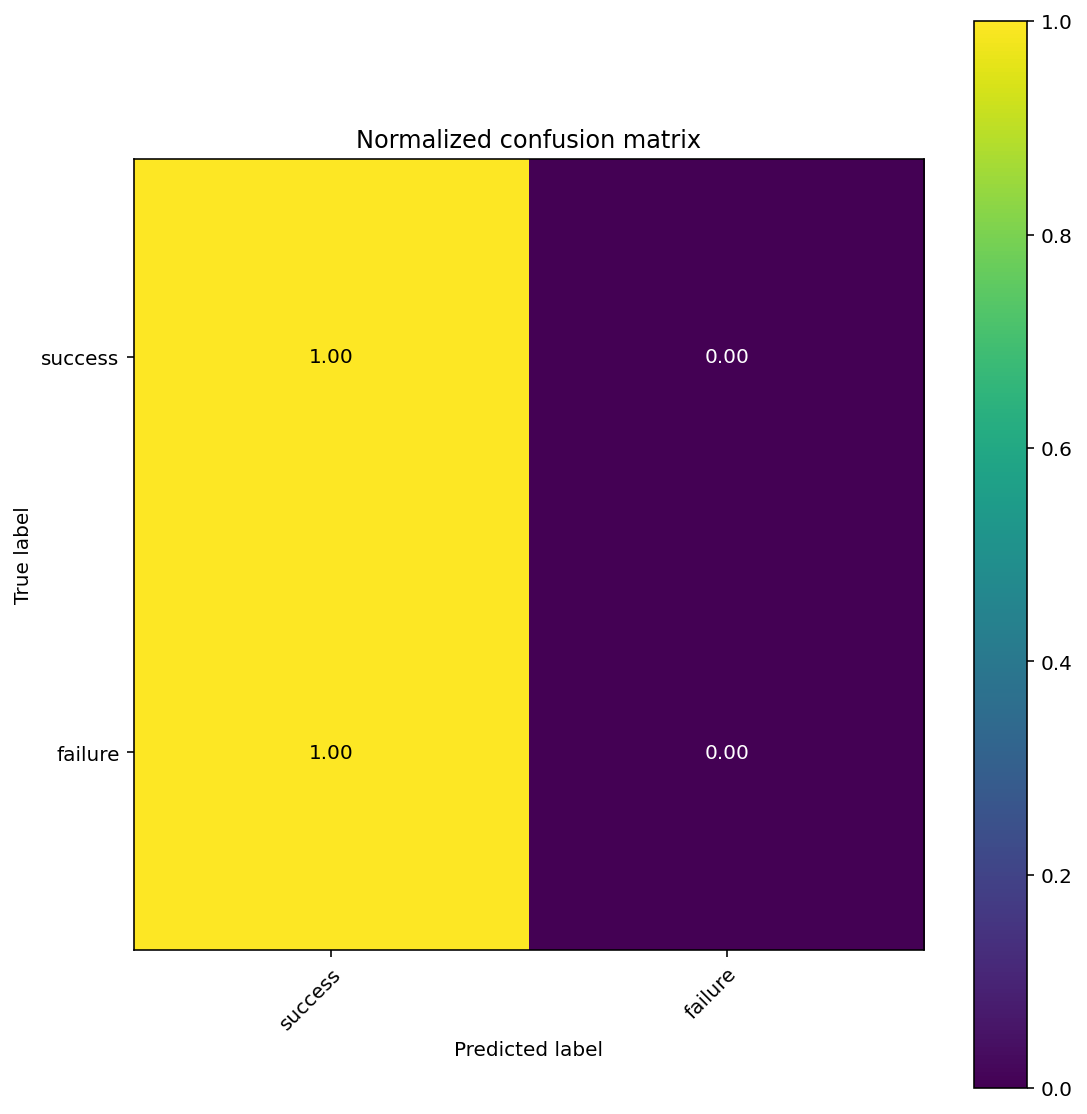

In [35]:
class_names = ["success", "failure"]
np_class_names = np.array(class_names)
plot_conf_mat(y_test, y_pred, np_class_names)